# An Introduction to the assign method and chaining in Pandas

## Intro

This article on the Pandas assign method is the first in a series of Professional Pandas blog posts that we will put out over the coming months. The goal of this series is to teach best practices about writing professional-grade pandas code. If you have questions or topics that you would like to dive into, please reach out.

In my opinion, one of the most underutilized methods in Pandas is the `.assign` method. My take (which may be extreme) is that `.assign` is the *one true way* to create a new column or update an existing column.

For those who don't want to read the whole article, here are my reasons for preferring `.assign`:

* You get around the dreaded `SettingWithCopyWarning`
* It enables chaining
* It forces you to write readable code that you, your future self, and your colleagues will appreciate
* It eases otherwise difficult operations

I get that this "only use `.assign`" may be extreme, but I encourage you to try it out first before you knock it. If you still hate it after trying it out, please send me your before and after code, because I am curious what happened.

For those still reading, let's jump in!

## Load data

To explore uses of the Pandas `.assign` method, I'm going to use a dataset of meteorological data from a ski resort called Alta.

This data set has some descriptive columns and some daily facts:

* *PRCP* - liquid precipitation (inches)
* *SNOW* - snowfall (inches) 
* *SNWD* - snow on the ground (inches)
* *TMAX* - maximum temperature (F)
* *TMIN* - minimum temperature (F)
* *TOBS* - temperature (F) at observation time

Let's load the data and create a `tweak_alta` function to pull out the columns we want.

In [ ]:
import modin.pandas as pd

raw = pd.read_csv('https://github.com/mattharrison/datasets/raw/master/data/alta-noaa-1980-2019.csv',
                  parse_dates=['DATE'])
def tweak_alta(df):
    return (df
            .loc[:, ['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 
                     'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'TOBS']]
           )
alta = tweak_alta(raw)

In [ ]:
alta

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS
0,USC00420072,"ALTA, UT US",40.5905,-111.6369,2660.9,1980-01-01,0.10,2.0,29.0,38.0,25.0,25.0
1,USC00420072,"ALTA, UT US",40.5905,-111.6369,2660.9,1980-01-02,0.43,3.0,34.0,27.0,18.0,18.0
2,USC00420072,"ALTA, UT US",40.5905,-111.6369,2660.9,1980-01-03,0.09,1.0,30.0,27.0,12.0,18.0
3,USC00420072,"ALTA, UT US",40.5905,-111.6369,2660.9,1980-01-04,0.00,0.0,30.0,31.0,18.0,27.0
4,USC00420072,"ALTA, UT US",40.5905,-111.6369,2660.9,1980-01-05,0.00,0.0,30.0,34.0,26.0,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...
14155,USC00420072,"ALTA, UT US",40.5905,-111.6369,2660.9,2019-09-03,0.01,0.0,0.0,74.0,57.0,73.0
14156,USC00420072,"ALTA, UT US",40.5905,-111.6369,2660.9,2019-09-04,0.00,0.0,0.0,77.0,52.0,74.0
14157,USC00420072,"ALTA, UT US",40.5905,-111.6369,2660.9,2019-09-05,0.00,0.0,0.0,76.0,54.0,65.0
14158,USC00420072,"ALTA, UT US",40.5905,-111.6369,2660.9,2019-09-06,0.07,0.0,0.0,66.0,52.0,60.0


(Notice that we are using the Modin library above, `import modin.pandas as pd`. However, this same code will run with the Pandas library by only changing that line to `import pandas as pd`.)

## Create a new column

A common operation is adding a column to a dataframe.

Most create a column by using index assignment. This is convenient because: 

* It looks like a dictionary operation that Python users are used to
* It (usually) overwrites the data making it a low overhead operation

There are also some disadvantages:

* It might cause a ``SettingWithCopyWarning``
* It does not return a dataframe. Hence it cannot be used in a chain of operations
* Many users create intermediate variables (and call ``.copy`` on the dataframe), thus removing the low overhead benefit

Below I will create a copy of the dataframe, ``alta_bad``, and add a new column, *PRCP_CM*, that stores daily precipitation measured in centimeters. This is how many folks add columns to dataframes:




In [ ]:
alta_bad = alta.copy()
alta_bad['PRCP_CM'] = alta_bad.PRCP * 2.54

## Using  ``.assign`` instead

I prefer using the `.assign` method to create new columns. It also has some advantages and disadvantages. The advantages are:

* It returns a new dataframe so you can chain operations
* It sidesteps the `SettingWithCopyWarning` completely. (As in, you will NEVER see it or deal with it).
* It makes your code read like a recipe
* It forces you to think about the order of column creation for dependent columns
* It allows you to create multiple columns
* It lets you merge in a dataframe

The disadvantages of using the `.assign` method in Pandas:

* It copies the dataframe (in the Pandas implementation)
* Because it uses keyword parameters, you are limited to column names that are valid Python parameter names (unless you do `**` unpacking with a dictionary that has the column stored as a key)
* It requires knowledge of `lambda` functions if you want to work on intermediate dataframes

Here is how I would add the *PRCP_CM* column using `.assign`:

In [ ]:
(alta
 .assign(PRCP_CM=alta.PRCP * 2.54)
)

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,PRCP_CM
0,USC00420072,"ALTA, UT US",40.5905,-111.6369,2660.9,1980-01-01,0.10,2.0,29.0,38.0,25.0,25.0,0.2540
1,USC00420072,"ALTA, UT US",40.5905,-111.6369,2660.9,1980-01-02,0.43,3.0,34.0,27.0,18.0,18.0,1.0922
2,USC00420072,"ALTA, UT US",40.5905,-111.6369,2660.9,1980-01-03,0.09,1.0,30.0,27.0,12.0,18.0,0.2286
3,USC00420072,"ALTA, UT US",40.5905,-111.6369,2660.9,1980-01-04,0.00,0.0,30.0,31.0,18.0,27.0,0.0000
4,USC00420072,"ALTA, UT US",40.5905,-111.6369,2660.9,1980-01-05,0.00,0.0,30.0,34.0,26.0,34.0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14155,USC00420072,"ALTA, UT US",40.5905,-111.6369,2660.9,2019-09-03,0.01,0.0,0.0,74.0,57.0,73.0,0.0254
14156,USC00420072,"ALTA, UT US",40.5905,-111.6369,2660.9,2019-09-04,0.00,0.0,0.0,77.0,52.0,74.0,0.0000
14157,USC00420072,"ALTA, UT US",40.5905,-111.6369,2660.9,2019-09-05,0.00,0.0,0.0,76.0,54.0,65.0,0.0000
14158,USC00420072,"ALTA, UT US",40.5905,-111.6369,2660.9,2019-09-06,0.07,0.0,0.0,66.0,52.0,60.0,0.1778


## Chaining Interlude

Let's take a break from discussing the `.assign` method for a moment.

This section might be controversial. My advice is to hold back your cringe reflex and hear me out. (Also, I would advise you to try out this style on your own code. My experience is that many who initially are repulsed by this have a wonderful epiphany when they try it, and it completely changes the way they write Pandas code.)

Folks who read my book, *Effective Pandas*, or follow my Pandas content know that I'm a big proponent of *chaining*.

What is chaining?

Chaining is writing a series of operations to a dataframe to manipulate it. Each operation works on the result of the previous operation. 


One complaint I have against the many "learn to use Pandas" blog posts scattered about the internet is that they teach a method in isolation. In practice, you almost never perform an operation to data in isolation. There are multiple operations that are required to change column types, update values, deal with missing data, aggregate, plot, etc. But generally, you only care about the end result. The intermediate data along the way is not important.

Let's assume that you wanted to summarize the Alta data by week. You might:

* Filter out columns
* Group by the date
* Aggregate different columns (by different functions)
* Create a new column with the *NAME* of the ski resort
* Create a new column with the weekly range

Let's also assume that the resort was named "Alta Ski Resort" before year 2000 and just "Alta" after.

Most folks would write code like this:


In [ ]:
my_cols =  ['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 
                     'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'TOBS']
df1 = alta[my_cols]
grouped_df = df1.groupby(pd.Grouper(key='DATE', freq='W'))
df2 = grouped_df.agg({'PRCP': 'sum', 'TMAX': 'max', 'TMIN': 'min', 'SNOW': 'sum', 'SNWD': 'mean'})
df3 = df2.reset_index()
df3[df3.DATE < '2000']['LOCATION'] = 'Alta Ski Resort'
df3[df3.DATE >= '2000']['LOCATION'] = 'Alta'
df3['T_RANGE'] = df3.TMAX - df3.TMIN
df3

,DATE,PRCP,TMAX,TMIN,SNOW,SNWD,T_RANGE
0,1980-01-06,0.68,42.0,12.0,7.0,30.500000,30.0
1,1980-01-13,8.76,33.0,-5.0,63.0,48.142857,38.0
2,1980-01-20,4.68,40.0,15.0,34.0,63.285714,25.0
3,1980-01-27,0.00,43.0,10.0,0.0,57.000000,33.0
4,1980-02-03,2.58,38.0,-6.0,40.0,70.571429,44.0
...,...,...,...,...,...,...,...
2066,2019-08-11,1.09,78.0,42.0,0.0,0.000000,36.0
2067,2019-08-18,0.00,75.0,42.0,0.0,0.000000,33.0
2068,2019-08-25,0.00,76.0,45.0,0.0,0.000000,31.0
2069,2019-09-01,0.02,78.0,41.0,0.0,0.000000,37.0


They would find that the lines:

```
df3[df3.DATE < '2000']['LOCATION'] = 'Alta Ski Resort'
df3[df3.DATE >= '2000']['LOCATION'] = 'Alta'
```

don't really work and would probably change them to this (after searching around on the internet):

In [ ]:
df3.loc[df3.DATE < '2000','LOCATION'] = 'Alta Ski Resort'
df3.loc[df3.DATE >= '2000','LOCATION'] = 'Alta'
df3

,DATE,PRCP,TMAX,TMIN,SNOW,SNWD,LOCATION,T_RANGE,SEASON
0,1980-01-06,0.68,42.0,12.0,7.0,30.500000,Alta Ski Resort,30.0,Ski 1979
1,1980-01-13,8.76,33.0,-5.0,63.0,48.142857,Alta Ski Resort,38.0,Ski 1979
2,1980-01-20,4.68,40.0,15.0,34.0,63.285714,Alta Ski Resort,25.0,Ski 1979
3,1980-01-27,0.00,43.0,10.0,0.0,57.000000,Alta Ski Resort,33.0,Ski 1979
4,1980-02-03,2.58,38.0,-6.0,40.0,70.571429,Alta Ski Resort,44.0,Ski 1979
...,...,...,...,...,...,...,...,...,...
2066,2019-08-11,1.09,78.0,42.0,0.0,0.000000,Alta,36.0,Summer 2019
2067,2019-08-18,0.00,75.0,42.0,0.0,0.000000,Alta,33.0,Summer 2019
2068,2019-08-25,0.00,76.0,45.0,0.0,0.000000,Alta,31.0,Summer 2019
2069,2019-09-01,0.02,78.0,41.0,0.0,0.000000,Alta,37.0,Summer 2019


Now let's add a *ski season* to the rows. Generally a ski season starts in November and ends in April.

In [ ]:
df3['SEASON'] = 'Summer'
df3.loc[(df3.DATE.dt.month <= 4) | (df3.DATE.dt.month >= 11),  'SEASON'] = 'Ski'
df3

,DATE,PRCP,TMAX,TMIN,SNOW,SNWD,LOCATION,T_RANGE,SEASON
0,1980-01-06,0.68,42.0,12.0,7.0,30.500000,Alta Ski Resort,30.0,Ski
1,1980-01-13,8.76,33.0,-5.0,63.0,48.142857,Alta Ski Resort,38.0,Ski
2,1980-01-20,4.68,40.0,15.0,34.0,63.285714,Alta Ski Resort,25.0,Ski
3,1980-01-27,0.00,43.0,10.0,0.0,57.000000,Alta Ski Resort,33.0,Ski
4,1980-02-03,2.58,38.0,-6.0,40.0,70.571429,Alta Ski Resort,44.0,Ski
...,...,...,...,...,...,...,...,...,...
2066,2019-08-11,1.09,78.0,42.0,0.0,0.000000,Alta,36.0,Summer
2067,2019-08-18,0.00,75.0,42.0,0.0,0.000000,Alta,33.0,Summer
2068,2019-08-25,0.00,76.0,45.0,0.0,0.000000,Alta,31.0,Summer
2069,2019-09-01,0.02,78.0,41.0,0.0,0.000000,Alta,37.0,Summer


Finally, let's add a year to the *SEASON*:



In [ ]:
df3['SEASON'] = df3.SEASON + ' ' + df3.DATE.dt.year.astype(str).where(df3.DATE.dt.month > 4, 
                                                        (df3.DATE.dt.year - 1).astype(str))
df3

,DATE,PRCP,TMAX,TMIN,SNOW,SNWD,LOCATION,T_RANGE,SEASON
0,1980-01-06,0.68,42.0,12.0,7.0,30.500000,Alta Ski Resort,30.0,Ski 1979
1,1980-01-13,8.76,33.0,-5.0,63.0,48.142857,Alta Ski Resort,38.0,Ski 1979
2,1980-01-20,4.68,40.0,15.0,34.0,63.285714,Alta Ski Resort,25.0,Ski 1979
3,1980-01-27,0.00,43.0,10.0,0.0,57.000000,Alta Ski Resort,33.0,Ski 1979
4,1980-02-03,2.58,38.0,-6.0,40.0,70.571429,Alta Ski Resort,44.0,Ski 1979
...,...,...,...,...,...,...,...,...,...
2066,2019-08-11,1.09,78.0,42.0,0.0,0.000000,Alta,36.0,Summer 2019
2067,2019-08-18,0.00,75.0,42.0,0.0,0.000000,Alta,33.0,Summer 2019
2068,2019-08-25,0.00,76.0,45.0,0.0,0.000000,Alta,31.0,Summer 2019
2069,2019-09-01,0.02,78.0,41.0,0.0,0.000000,Alta,37.0,Summer 2019


This looks ok, and you have probably seen code like this. You've probably written code like this if you are reading this post.

It does have some issues. It spans multiple cells, creates unneeded intermediate variables, and might be buggy (note that the *LOCATION* column initially failed silently).

Let's use the Pandas `.assign` method and chaining to write it a little differently.

In [ ]:
def monthly_summary(df):
    my_cols =  ['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 
                     'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'TOBS']
    return (df
            [my_cols]
            .groupby(pd.Grouper(key='DATE', freq='W'))
            .agg({'PRCP': 'sum', 'TMAX': 'max', 'TMIN': 'min', 'SNOW': 'sum', 'SNWD': 'mean'})
            .reset_index()
            .assign(LOCATION='Alta', 
                    SEASON='Ski')
            .assign(LOCATION=lambda df_: df_.LOCATION.where(df_.DATE.dt.year >= 2000, 'Alta Ski Resort'),
                    T_RANGE=lambda df_: df_.TMAX - df_.TMIN,
                    SEASON=lambda df_:(df_
                                       .SEASON
                                       .where((df_.DATE.dt.month <= 4) | (df_.DATE.dt.month >= 11), 'Summer')
                                       .add(' ')
                                       .add(df_
                                            .DATE.dt.year.astype(str)
                                            .where(df_.DATE.dt.month > 4, (df_.DATE.dt.year - 1).astype(str))))
                   )
           )
monthly_summary(alta)

,DATE,PRCP,TMAX,TMIN,SNOW,SNWD,LOCATION,SEASON,T_RANGE
0,1980-01-06,0.68,42.0,12.0,7.0,30.500000,Alta Ski Resort,Ski 1979,30.0
1,1980-01-13,8.76,33.0,-5.0,63.0,48.142857,Alta Ski Resort,Ski 1979,38.0
2,1980-01-20,4.68,40.0,15.0,34.0,63.285714,Alta Ski Resort,Ski 1979,25.0
3,1980-01-27,0.00,43.0,10.0,0.0,57.000000,Alta Ski Resort,Ski 1979,33.0
4,1980-02-03,2.58,38.0,-6.0,40.0,70.571429,Alta Ski Resort,Ski 1979,44.0
...,...,...,...,...,...,...,...,...,...
2066,2019-08-11,1.09,78.0,42.0,0.0,0.000000,Alta,Summer 2019,36.0
2067,2019-08-18,0.00,75.0,42.0,0.0,0.000000,Alta,Summer 2019,33.0
2068,2019-08-25,0.00,76.0,45.0,0.0,0.000000,Alta,Summer 2019,31.0
2069,2019-09-01,0.02,78.0,41.0,0.0,0.000000,Alta,Summer 2019,37.0


## A False positive Issue

One common comment that I hear when folks see code that looks like `monthly_summary` is: "This code must be hard to debug." 

I beg to differ. It is written as a chain. But I didn't write out all the code at once. I wrote one operation at a time. Then I ran the code and validated (debugged) that it was doing what I wanted.

There are a few pleasant aspects of code written this way. First, it is encapsulated in a function. This makes it easy to pull out into a script and use elsewhere. Also, because it is a function, there aren't any intermediate variables hanging around messing up the global namespace. For example, the `my_cols` variable is garbage collected when the function has finished executing.

Also, this chain reads like a recipe of steps:

* Pull out the columns
* Groupby by the date with a weekly (`'W'`) frequency
* Aggregate the columns as indicated
* Push the index (the week date) into a column
* Add a temperature range (*T_RANGE*) column
* Add columns for *LOCATION* and *SEASON*
* Update the *LOCATION* and *SEASON* columns with logic

In fact, writing chains forces you to think about each step that you will perform on the data. It is a constraint that I find allows me to write better code. (Again, you might think I'm spewing crazy talk. Try it out and see how it helps with your code.)

This code is also easy to execute. It is all in one place. Another struggle with notebooks is cells strewn with data manipulation logic (that can be executed in arbitrary order). With the chained code, you can come back to this notebook in the future and run this cell with confidence, knowing that you weren't missing running other random cells from the notebook.

Debugging this code is easy as well. I'm not going to dive into that here as I have devoted a whole chapter to that in my book, *Effective Pandas* (maybe I will do a future blog post on debugging if there is interest). In short, you can comment out the operations to see previous intermediate results or combine a `.pipe` call with a `breakpoint()` to jump into the debugger if you really want to.

## Real Issues with `.assign`

Everything is not peaches and cream with the `.assign` method. There are some real issues with this code. One is that it requires understanding `lambda` expressions.

However, I think if you want to be a serious user of Pandas, it pays off to take a few minutes to understand `lambda` functions.

We use `lambda` expressions to create *anonymous functions*. These are just functions that we can inline in a call. In fact, we don't really need to use them. We can define a normal function instead. I could write the line:

```
            .assign(T_RANGE=lambda df_: df_.TMAX - df_.TMIN,
```

As 

```
            .assign(T_RANGE=calc_range,
```

If I had a `calc_range` function defined as:

```
def calc_range(df_):
    return df_.TMAX - df_.TMIN,
```

(Note I use the variable `df_` in my `lambda` to distinguish it from `df` that was passed into the `monthly_summary` function.)

Using a `lambda` function (or a normal function) with `.assign` passes in the *current state* of the dataframe into the function. Because we have aggregated the daily data to a weekly level, we can only calculate the weekly range from the current data and not the original daily data, `df`. 

The `lambda` accepts the current state of the dataframe and should return a scalar value or a series to use for the new or updated column values.

The lines:

```
            .assign(...
                    LOCATION='Alta', 
                    SEASON='Ski')
```


Create columns for *LOCATION* and *SEASON* with a single value. You can also set them to a series as well. They don't need `lambda`s because we are not dependent on the current state of the dataframe.

Another "issue" with `.assign` is that we need a new call to it if we want to update a column again (like we do with *LOCATION* and *SEASON*). (Because `.assign` is leveraging named parameters in Python, we can't have two parameters with the same name).

Complaints that this code is "complicated" are valid, in my opinion. But the complication comes from Pandas' lack of providing a clean interface for *if*/*else* logic, not from the chain. 

(I personally find the `.where` method lacking and wish that Pandas had something similar to NumPy's `select` function for implementing conditional logic.)

## Further refactoring

To address the "complicated" nature of creating the *LOCATION* and *SEASON* columns, you might consider refactoring the logic to create these columns into a function:

In [ ]:
def monthly_summary(df):
    def get_location(df_):
        return (df_
                .assign(LOCATION='Alta')
                .LOCATION
                .where(df_.DATE.dt.year >= 2000, 'Alta Ski Resort')
               )
    
    def get_season(df_):
        return (df_
                .assign(SEASON='Ski')
                .SEASON
                .where((df_.DATE.dt.month <= 4) | (df_.DATE.dt.month >= 11), 'Summer')
                .add(' ')
                .add(df_
                   .DATE.dt.year.astype(str)
                   .where(df_.DATE.dt.month > 4, (df_.DATE.dt.year - 1).astype(str)))
               )
    
    my_cols =  ['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 
                'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'TOBS']
    return (df
            [my_cols]
            .groupby(pd.Grouper(key='DATE', freq='W'))
            .agg({'PRCP': 'sum', 'TMAX': 'max', 'TMIN': 'min', 'SNOW': 'sum', 'SNWD': 'mean'})
            .reset_index()
            .assign(T_RANGE=lambda df_: df_.TMAX - df_.TMIN,
                    LOCATION=get_location,
                    SEASON=get_season
                   )
           )
monthly_summary(alta)

,DATE,PRCP,TMAX,TMIN,SNOW,SNWD,T_RANGE,LOCATION,SEASON
0,1980-01-06,0.68,42.0,12.0,7.0,30.500000,30.0,Alta Ski Resort,Ski 1979
1,1980-01-13,8.76,33.0,-5.0,63.0,48.142857,38.0,Alta Ski Resort,Ski 1979
2,1980-01-20,4.68,40.0,15.0,34.0,63.285714,25.0,Alta Ski Resort,Ski 1979
3,1980-01-27,0.00,43.0,10.0,0.0,57.000000,33.0,Alta Ski Resort,Ski 1979
4,1980-02-03,2.58,38.0,-6.0,40.0,70.571429,44.0,Alta Ski Resort,Ski 1979
...,...,...,...,...,...,...,...,...,...
2066,2019-08-11,1.09,78.0,42.0,0.0,0.000000,36.0,Alta,Summer 2019
2067,2019-08-18,0.00,75.0,42.0,0.0,0.000000,33.0,Alta,Summer 2019
2068,2019-08-25,0.00,76.0,45.0,0.0,0.000000,31.0,Alta,Summer 2019
2069,2019-09-01,0.02,78.0,41.0,0.0,0.000000,37.0,Alta,Summer 2019


## Create a plot

Ok, a weekly summary is nice. But the goal of most manipulating data is not the individual step but creating a result that we can use to inspire, inform, or take action. Let's use Matplotlib to create a plot of snow on the ground during a season.

This is similar to what is found in my book, *Pandas Cookbook 1.x*, and was inspired by a plot created by Trud Antzee (`@Antzee_`).



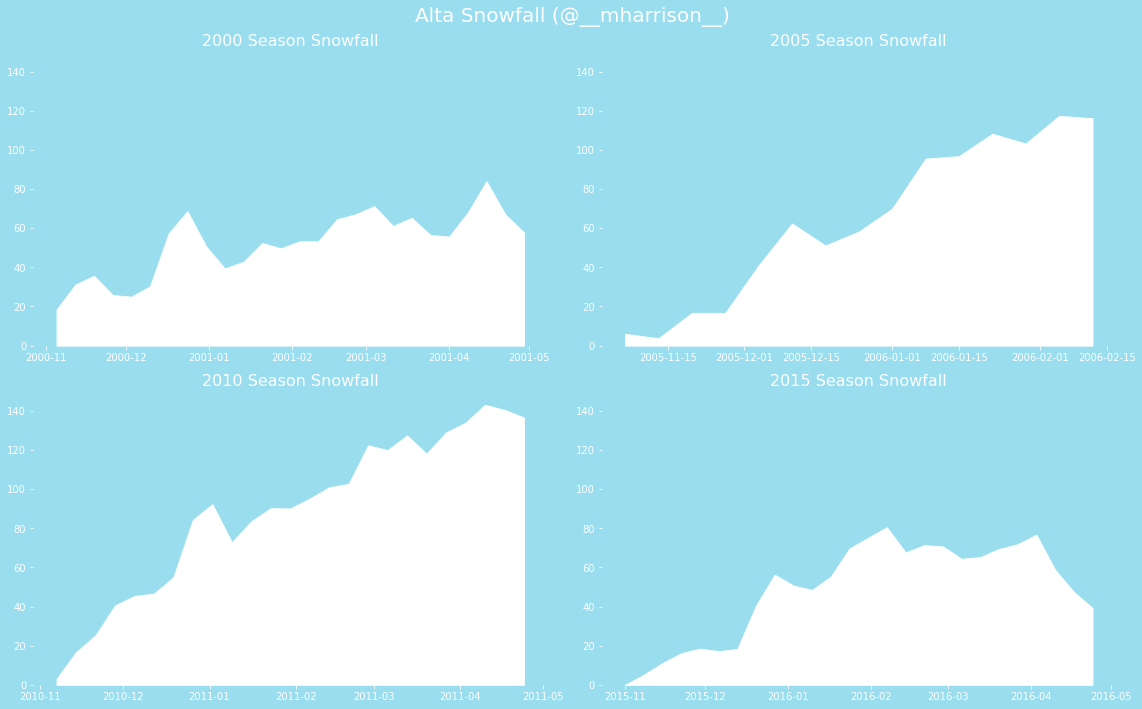

In [ ]:
import matplotlib.pyplot as plt

def plot_season(df, year, fig, ax):
    blue = '#99ddee'
    white = '#fff'
    data = (df
     .query(f'SEASON=="Ski {year}"')
    )
    for side in 'top,right,bottom,left'.split(','):
        ax.spines[side].set_visible(False)
    ax.tick_params(axis='both', colors=white)
    ax.tick_params(axis='both', colors=white)
    ax.tick_params(axis='x', which='minor', colors=white)
    ax.fill_between(data.DATE, data.SNWD, color='white')
    ax.set_facecolor(blue)
    ax.set_ylim(0, 150)
    ax.set_title(f'{year} Season Snowfall', fontsize=16, color=white)

def facet_plot(df, years):
    blue = '#99ddee'
    white = '#fff'
    fig, axs = plt.subplots(ncols=2, nrows=(len(years)//2),
                          figsize=(16, 10), facecolor=blue)
    axs = axs.flatten()
    for i, year in enumerate(years):
        plot_season(df, year, fig, axs[i])
    fig.suptitle('Alta Snowfall (@__mharrison__)', fontsize=20, color=white)
    fig.tight_layout()
    return fig
    
_ = (monthly_summary(alta)
 .pipe(facet_plot, years=['2000', '2005','2010', '2015'])
)    

## Final Code

Thanks for getting this far. I hope you have a better understanding of using the `.assign` method. Also I hope you appreciate that operations do not occur in isolation. 

We showed how to take "traditional" Pandas code, refactor it into chains and functions. I would love to hear your feedback. How are you going to use the `.assign` method? Please share examples of applying chains like this to your code on Twitter, and tag @ponderdata and @\_\_mharrison\_\_. What insights did you have as you were doing it?


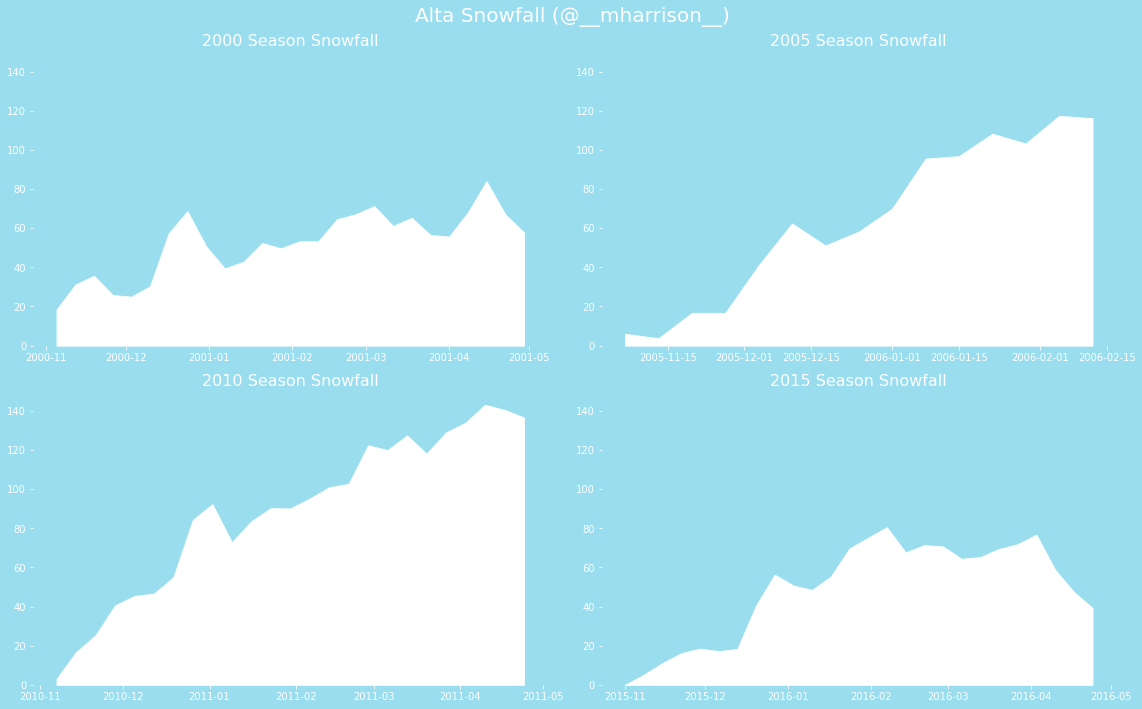

In [ ]:
import matplotlib.pyplot as plt
import modin.pandas as pd

raw = pd.read_csv('https://github.com/mattharrison/datasets/raw/master/data/alta-noaa-1980-2019.csv',
                  parse_dates=['DATE'])

def tweak_alta(df):
    return (df
            .loc[:, ['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 
                     'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'TOBS']]
           )

def monthly_summary(df):
    def get_location(df_):
        return (df_
                .assign(LOCATION='Alta')
                .LOCATION
                .where(df_.DATE.dt.year >= 2000, 'Alta Ski Resort')
               )
    
    def get_season(df_):
        return (df_
                .assign(SEASON='Ski')
                .SEASON
                .where((df_.DATE.dt.month <= 4) | (df_.DATE.dt.month >= 11), 'Summer')
                .add(' ')
                .add(df_
                   .DATE.dt.year.astype(str)
                   .where(df_.DATE.dt.month > 4, (df_.DATE.dt.year - 1).astype(str)))
               )
    
    my_cols =  ['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 
                'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'TOBS']
    return (df
            [my_cols]
            .groupby(pd.Grouper(key='DATE', freq='W'))
            .agg({'PRCP': 'sum', 'TMAX': 'max', 'TMIN': 'min', 'SNOW': 'sum', 'SNWD': 'mean'})
            .reset_index()
            .assign(T_RANGE=lambda df_: df_.TMAX - df_.TMIN,
                    LOCATION=get_location,
                    SEASON=get_season
                   )
           )

def plot_season(df, year, fig, ax):
    blue = '#99ddee'
    white = '#fff'
    data = (df
     .query(f'SEASON=="Ski {year}"')
    )
    for side in 'top,right,bottom,left'.split(','):
        ax.spines[side].set_visible(False)
    ax.tick_params(axis='both', colors=white)
    ax.tick_params(axis='both', colors=white)
    ax.tick_params(axis='x', which='minor', colors=white)
    ax.fill_between(data.DATE, data.SNWD, color='white')
    ax.set_facecolor(blue)
    ax.set_ylim(0, 150)
    ax.set_title(f'{year} Season Snowfall', fontsize=16, color=white)

def facet_plot(df, years):
    blue = '#99ddee'
    white = '#fff'
    fig, axs = plt.subplots(ncols=2, nrows=(len(years)//2),
                          figsize=(16, 10), facecolor=blue)
    axs = axs.flatten()
    for i, year in enumerate(years):
        plot_season(df, year, fig, axs[i])
    fig.suptitle('Alta Snowfall (@__mharrison__)', fontsize=20, color=white)
    fig.tight_layout()
    return fig
    

_ = (raw
     .pipe(tweak_alta)
     .pipe(monthly_summary)
     .pipe(facet_plot, years=['2000', '2005','2010', '2015'])
)    


## Ponder

Ponder is the company that is driving Modin and pushing to scale Pandas with you. If you want to scale your Pandas code out to large datasets by changing a single line of code, try the Modin library. If you need help running your Pandas workloads in production at scale, talk to us!